In [25]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from typing import List, Tuple, Optional, Dict, Any, Union, Callable, Iterable

In [2]:
from scaling.utils import (
    get_pareto_frontier, get_final_points_from_curve_set, fit_linear_model
)
from scaling.visualize import visualize_train_curves, plot_line_fit

In [3]:
warmstarting_df = pd.read_parquet(
    "../data/warmstarting_results.parquet",
)
display(warmstarting_df)

tag,tokens,flops,Train Loss,Validation Loss,tkpm,base_N,target_N,shrink,width,depth,max_lr,warmup,cooldown,seed,method,train_loss_smoothed
0,0,0.000000e+00,10.957504,10.984583,10.0,14562560,32270848,0.2,256,8,0.0030,0.01,0.2,666,warmstart,4.689124
1,65536,1.268941e+13,11.012417,NaN,10.0,14562560,32270848,0.2,256,8,0.0030,0.01,0.2,666,warmstart,4.688708
2,131072,2.537883e+13,10.583125,NaN,10.0,14562560,32270848,0.2,256,8,0.0030,0.01,0.2,666,warmstart,4.687878
3,196608,3.806824e+13,9.702733,NaN,10.0,14562560,32270848,0.2,256,8,0.0030,0.01,0.2,666,warmstart,4.686633
4,262144,5.075766e+13,8.710074,NaN,10.0,14562560,32270848,0.2,256,8,0.0030,0.01,0.2,666,warmstart,4.684977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588810,5742264320,9.894497e+18,1.816024,NaN,30.0,77124608,287183360,0.4,1280,8,0.0025,0.01,0.2,666,warmstart,1.645748
3588811,5742526464,9.894948e+18,1.557958,NaN,30.0,77124608,287183360,0.4,1280,8,0.0025,0.01,0.2,666,warmstart,1.645747
3588812,5742788608,9.895400e+18,1.735591,NaN,30.0,77124608,287183360,0.4,1280,8,0.0025,0.01,0.2,666,warmstart,1.645747
3588813,5743050752,9.895852e+18,1.498406,NaN,30.0,77124608,287183360,0.4,1280,8,0.0025,0.01,0.2,666,warmstart,1.645747


In [4]:
# retaining only warmstarting results

warmstarting_df = warmstarting_df.loc[warmstarting_df.method != "mup"]
display(warmstarting_df)

tag,tokens,flops,Train Loss,Validation Loss,tkpm,base_N,target_N,shrink,width,depth,max_lr,warmup,cooldown,seed,method,train_loss_smoothed
0,0,0.000000e+00,10.957504,10.984583,10.0,14562560,32270848,0.2,256,8,0.0030,0.01,0.2,666,warmstart,4.689124
1,65536,1.268941e+13,11.012417,NaN,10.0,14562560,32270848,0.2,256,8,0.0030,0.01,0.2,666,warmstart,4.688708
2,131072,2.537883e+13,10.583125,NaN,10.0,14562560,32270848,0.2,256,8,0.0030,0.01,0.2,666,warmstart,4.687878
3,196608,3.806824e+13,9.702733,NaN,10.0,14562560,32270848,0.2,256,8,0.0030,0.01,0.2,666,warmstart,4.686633
4,262144,5.075766e+13,8.710074,NaN,10.0,14562560,32270848,0.2,256,8,0.0030,0.01,0.2,666,warmstart,4.684977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3588810,5742264320,9.894497e+18,1.816024,NaN,30.0,77124608,287183360,0.4,1280,8,0.0025,0.01,0.2,666,warmstart,1.645748
3588811,5742526464,9.894948e+18,1.557958,NaN,30.0,77124608,287183360,0.4,1280,8,0.0025,0.01,0.2,666,warmstart,1.645747
3588812,5742788608,9.895400e+18,1.735591,NaN,30.0,77124608,287183360,0.4,1280,8,0.0025,0.01,0.2,666,warmstart,1.645747
3588813,5743050752,9.895852e+18,1.498406,NaN,30.0,77124608,287183360,0.4,1280,8,0.0025,0.01,0.2,666,warmstart,1.645747


### Visualize raw data

Visualize all learning curves across N, D available in the *training set* to see scaling patterns.

Optionally, consider visualizing for different hyperparameters.

In [5]:
unique_col_list = ["base_N", "target_N", "tkpm", "shrink"]
y_col = "train_loss_smoothed"
x_col = "flops"  # "tokens"

<Figure size 640x480 with 0 Axes>

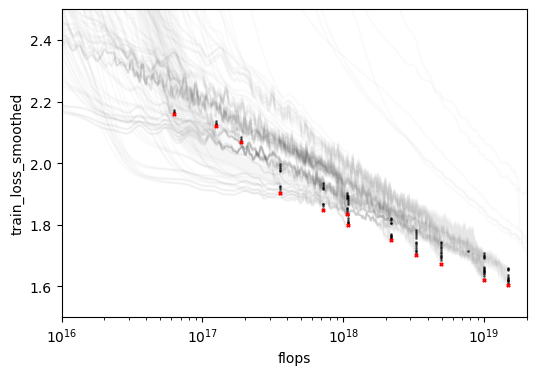

In [6]:
plt.clf()
fig, ax = plt.subplots(figsize=(6, 4))

pareto_df = visualize_train_curves(
    ax, 
    warmstarting_df,
    unique_col_list,
    x_col=x_col,
    y_col=y_col,
    plot_all_curves=True,
    plot_final=True,
    plot_pareto_final=True,
    ylims=(1.5, 2.5),
    xlims=(1e16, 2e19),
    xlog=True,
)

In [7]:
pareto_df.sort_values(by='flops')

tag,tokens,flops,Train Loss,Validation Loss,tkpm,base_N,target_N,shrink,width,depth,max_lr,warmup,cooldown,seed,method,train_loss_smoothed
9847,322633728,6.246998e+16,2.082877,2.244467,10.0,14562560,32270848,0.4,256,8,0.0030,0.01,0.2,666,warmstart,2.158544
44315,645332992,1.249527e+17,1.975347,2.174510,20.0,14562560,32270848,0.4,256,8,0.0030,0.01,0.2,666,warmstart,2.121203
103403,968032256,1.874353e+17,2.098853,2.137143,30.0,14562560,32270848,0.4,256,8,0.0030,0.01,0.2,666,warmstart,2.069295
1795364,771096576,3.568231e+17,1.832548,1.983345,10.0,32270848,77124608,0.2,512,8,0.0050,0.01,0.2,666,warmstart,1.901639
1830668,1542324224,7.137069e+17,2.004670,1.925928,20.0,32270848,77124608,0.2,512,8,0.0050,0.01,0.2,666,warmstart,1.846509
1895392,2313551872,1.070591e+18,1.810897,1.898846,30.0,32270848,77124608,0.2,512,8,0.0050,0.01,0.2,666,warmstart,1.833948
2758961,1345323008,1.086170e+18,1.903821,1.809408,10.0,77124608,134561280,0.4,768,8,0.0025,0.01,0.2,666,warmstart,1.799347
2784626,2690908160,2.172552e+18,1.690731,1.758246,20.0,77124608,134561280,0.2,768,8,0.0025,0.01,0.2,666,warmstart,1.749756
2841089,4036493312,3.258934e+18,1.575103,1.730615,30.0,77124608,134561280,0.2,768,8,0.0025,0.01,0.2,666,warmstart,1.702631
2913640,2871525376,4.947926e+18,1.598231,1.694707,10.0,77124608,287183360,0.2,1280,8,0.0025,0.01,0.2,666,warmstart,1.672560


### Approach 1

Fit for `C vs N` and `C vs D`, assuming *best* training run for each `(N, D)`.

Steps:

1. Visualize for `C vs N` and `C vs D`
2. Fit linear model for each of them

tag,tokens,flops,Train Loss,Validation Loss,tkpm,base_N,target_N,shrink,width,depth,max_lr,warmup,cooldown,seed,method,train_loss_smoothed
9847,322633728,6.246998e+16,2.082877,2.244467,10.0,14562560,32270848,0.4,256,8,0.003,0.01,0.2,666,warmstart,2.158544
44315,645332992,1.249527e+17,1.975347,2.174510,20.0,14562560,32270848,0.4,256,8,0.003,0.01,0.2,666,warmstart,2.121203
103403,968032256,1.874353e+17,2.098853,2.137143,30.0,14562560,32270848,0.4,256,8,0.003,0.01,0.2,666,warmstart,2.069295
1795364,771096576,3.568231e+17,1.832548,1.983345,10.0,32270848,77124608,0.2,512,8,0.005,0.01,0.2,666,warmstart,1.901639
1830668,1542324224,7.137069e+17,2.004670,1.925928,20.0,32270848,77124608,0.2,512,8,0.005,0.01,0.2,666,warmstart,1.846509


<Figure size 640x480 with 0 Axes>

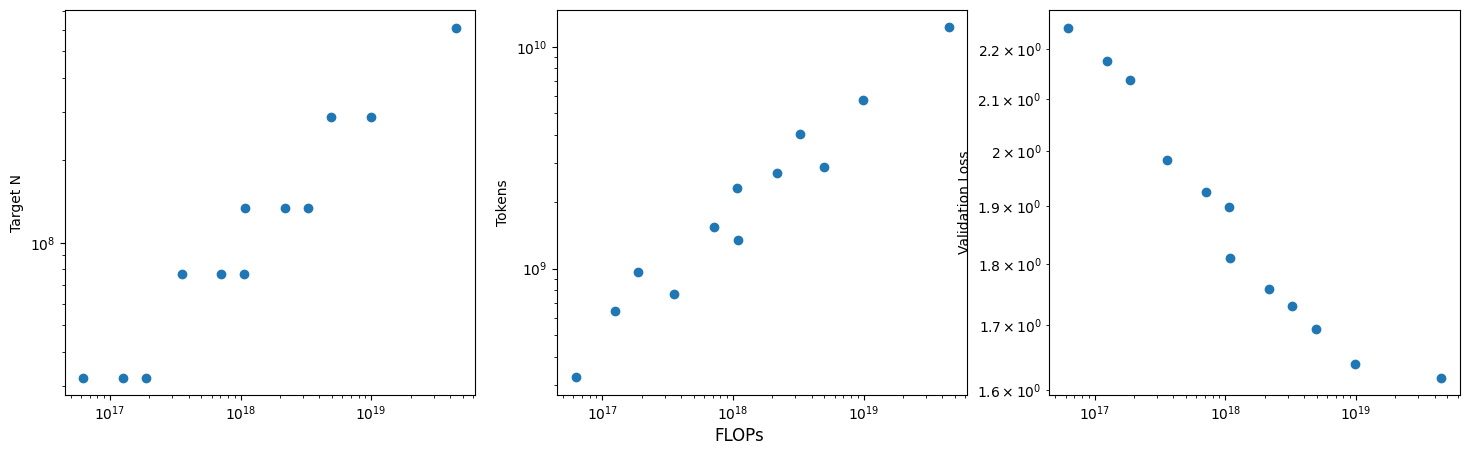

In [8]:
x_col = "flops"
y_col = "Validation Loss"

_pareto_df = get_final_points_from_curve_set(
    warmstarting_df,
    unique_col_list,
    x_col=x_col,
    y_col=y_col,
    get_pareto=True,
)

display(_pareto_df.head())

plt.clf()
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

plot_line_fit(
    ax[0],
    X = _pareto_df[x_col],
    Y = _pareto_df["target_N"]
)
ax[0].set_ylabel("Target N")

plot_line_fit(
    ax[1],
    X = _pareto_df[x_col],
    Y = _pareto_df["tokens"],
)
ax[1].set_ylabel("Tokens")

plot_line_fit(
    ax[2],
    X = _pareto_df[x_col],
    Y = _pareto_df[y_col],
)
ax[2].set_ylabel(y_col)

fig.supxlabel("FLOPs")

for ax in ax.flat:
    leg = ax.get_legend()
    if leg:
        leg.remove()


##### Using the largest model scale as the held out

In [9]:
# Creating held out over pareto df HERE

train_df = _pareto_df.loc[_pareto_df.target_N != sorted(_pareto_df.target_N.unique())[-1]]
held_out_df = _pareto_df.loc[_pareto_df.target_N == sorted(_pareto_df.target_N.unique())[-1]]
held_out_df

tag,tokens,flops,Train Loss,Validation Loss,tkpm,base_N,target_N,shrink,width,depth,max_lr,warmup,cooldown,seed,method,train_loss_smoothed
1758430,12208570368,4.471914e+19,1.623363,1.619206,20.0,14562560,610488320,0.2,2048,8,0.003,0.01,0.2,666,warmstart,1.604088


Slope: 0.47977528328213065, Intercept: -1.488185951189827, R^2: 0.9159454613393441
Slope: 0.5202247167178695, Intercept: -0.3035735180382275, R^2: 0.9275988396030581
Slope: -0.06609042031961475, Intercept: 3.369107264083996, R^2: 0.9790529448371146


<Figure size 640x480 with 0 Axes>

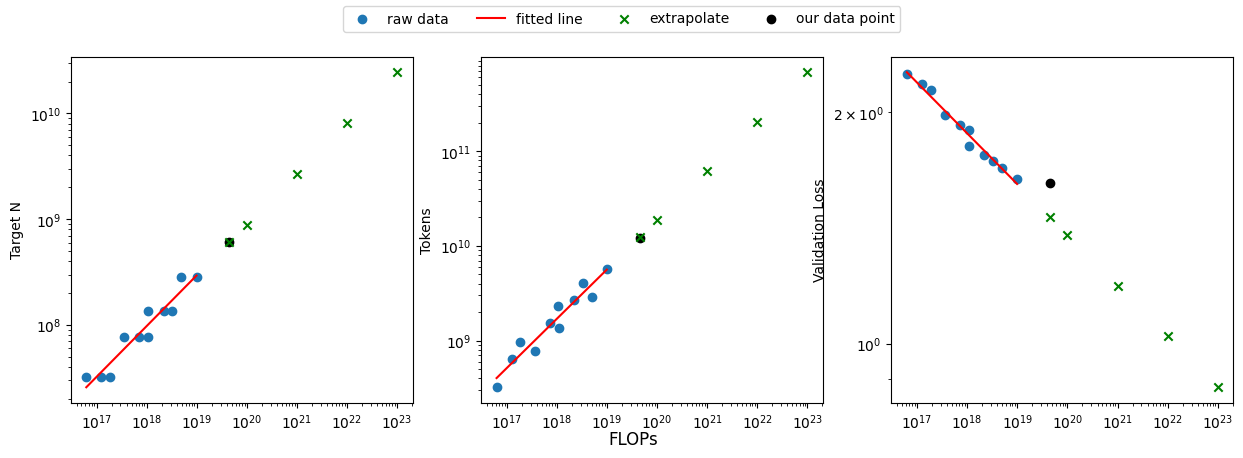

In [10]:
# Visualizing scaling law linear fit for C vs N, D, L

plt.clf();
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5));

# C vs N

X = train_df[x_col].values
Y = train_df["target_N"].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[0],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=[held_out_df.flops.values[0], 1e20, 1e21, 1e22, 1e23],
    y_extrapolate=[held_out_df["target_N"].values[0]],
)
ax[0].set_ylabel("Target N")


# C vs D

X = train_df[x_col].values
Y = train_df["tokens"].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[1],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=[held_out_df.flops.values[0], 1e20, 1e21, 1e22, 1e23],
    y_extrapolate=[held_out_df.tokens.values[0]],
)
ax[1].set_ylabel("Tokens")

# C vs Loss

X = train_df[x_col].values
Y = train_df[y_col].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[2],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=[held_out_df.flops.values[0], 1e20, 1e21, 1e22, 1e23],
    y_extrapolate=[held_out_df[y_col].values[0]],
)
ax[2].set_ylabel(y_col)

fig.supxlabel("FLOPs")

handles, labels = ax[0].get_legend_handles_labels()
for ax in ax.flat:
    leg = ax.get_legend()
    if leg:
        leg.remove()
fig.legend(handles, labels, loc="upper center", ncol=4)

##### Using the top-2 model scales as the held out

In [11]:
# Creating held out over pareto df HERE

train_df = _pareto_df.loc[_pareto_df.target_N.isin(sorted(_pareto_df.target_N.unique())[:-2])]
held_out_df = _pareto_df.loc[_pareto_df.target_N.isin(sorted(_pareto_df.target_N.unique())[-2:])]
held_out_df = held_out_df.loc[held_out_df.tkpm.isin(train_df.tkpm.unique())]
held_out_df

tag,tokens,flops,Train Loss,Validation Loss,tkpm,base_N,target_N,shrink,width,depth,max_lr,warmup,cooldown,seed,method,train_loss_smoothed
2913640,2871525376,4.947926e+18,1.598231,1.694707,10.0,77124608,287183360,0.2,1280,8,0.0025,0.01,0.2,666,warmstart,1.672560
2979370,5743312896,9.896303e+18,1.526955,1.639807,20.0,77124608,287183360,0.2,1280,8,0.0025,0.01,0.2,666,warmstart,1.633155
1758430,12208570368,4.471914e+19,1.623363,1.619206,20.0,14562560,610488320,0.2,2048,8,0.0030,0.01,0.2,666,warmstart,1.604088


Slope: 0.4351570867102757, Intercept: 0.3000921875914777, R^2: 0.8703189017116929
Slope: 0.564842913289725, Intercept: -2.0918516568195606, R^2: 0.9187484531608149
Slope: -0.06993298543099756, Intercept: 3.523733387725398, R^2: 0.9741146806223495


<Figure size 640x480 with 0 Axes>

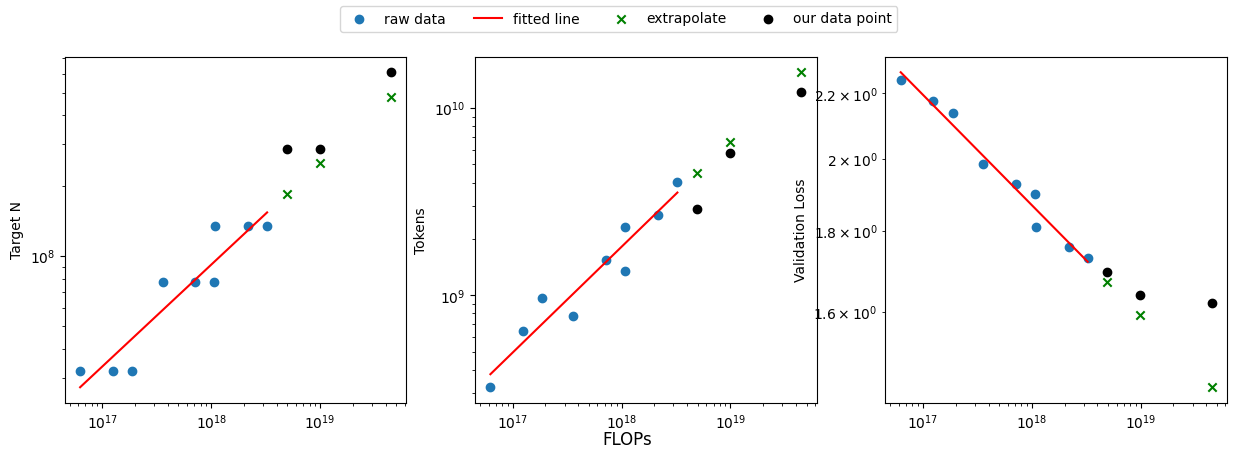

In [12]:
# Visualizing scaling law linear fit for C vs N, D, L

plt.clf();
fig, ax = plt.subplots(1, 3, figsize=(15, 4.5));

# C vs N

X = train_df[x_col].values
Y = train_df["target_N"].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[0],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=held_out_df.flops.values,
    y_extrapolate=held_out_df["target_N"].values,
)
ax[0].set_ylabel("Target N")


# C vs D

X = train_df[x_col].values
Y = train_df["tokens"].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[1],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=held_out_df.flops.values,
    y_extrapolate=held_out_df.tokens.values,
)
ax[1].set_ylabel("Tokens")

# C vs Loss

X = train_df[x_col].values
Y = train_df[y_col].values
slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")

plot_line_fit(
    ax[2],
    X,
    Y,
    slope,
    intercept,
    x_extrapolate=held_out_df.flops.values,
    y_extrapolate=held_out_df[y_col].values,
)
ax[2].set_ylabel(y_col)

fig.supxlabel("FLOPs")

handles, labels = ax[0].get_legend_handles_labels()
for ax in ax.flat:
    leg = ax.get_legend()
    if leg:
        leg.remove()
fig.legend(handles, labels, loc="upper center", ncol=4)

#### Fixed Base Model

In [13]:
# Visualize the Pareto Front and display to what algorithm it belongs (I think we just have muP and Paws...)

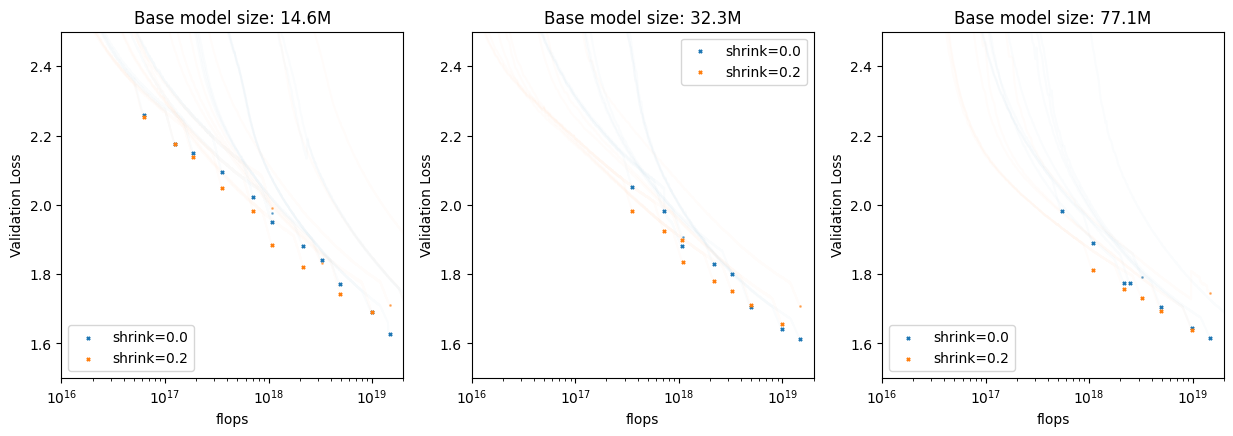

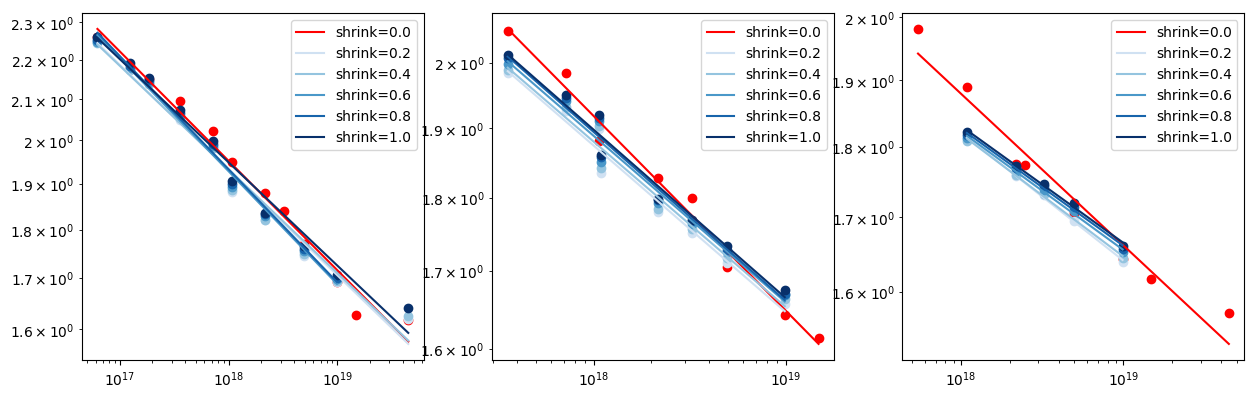

In [19]:
warmstarting_df = pd.read_parquet(
    "../data/warmstarting_results.parquet",
)
base_model_sizes = warmstarting_df['base_N'].unique()

# create a plot with len(basemodel sizes) many axes
fig, axes = plt.subplots(1, len(base_model_sizes), figsize=(5 * len(base_model_sizes), 4.5));
fig2, axes2 = plt.subplots(1, len(base_model_sizes), figsize=(5 * len(base_model_sizes), 4.5));

for i, base_model_size in enumerate(base_model_sizes):
    base_size_df = warmstarting_df[warmstarting_df['base_N'] == base_model_size]
    
    axes[i].set_title(f"Base model size: {(base_model_size/1_000_000):3.1f}M")
    # plot for the different scaling factors 
    # get a color gradient

    shrink_factors = sorted(base_size_df['shrink'].unique())
    colors = plt.cm.Blues(np.linspace(0, 1, len(shrink_factors)))
    for j, shrink in enumerate(shrink_factors):
        shrink_df = base_size_df[base_size_df['shrink']==shrink]
        if shrink in [0.0, 0.2]:
            visualize_train_curves(
                axes[i], 
                shrink_df,
                unique_col_list,
                x_col=x_col,
                y_col=y_col,
                plot_all_curves=True,
                plot_final=True,
                plot_pareto_final=True,
                ylims=(1.5, 2.5),
                xlims=(1e16, 2e19),
                xlog=True,
                style={"color": plt.get_cmap("tab10").colors[j], "label": f"shrink={shrink}"})

        pareto_shrink_df = get_final_points_from_curve_set(
            shrink_df,
            unique_col_list,
            x_col=x_col,
            y_col=y_col,
            get_pareto=True,
        )
            
        X = pareto_shrink_df[x_col].values
        Y = pareto_shrink_df[y_col].values

        slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
        # print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")
        if shrink == 0.:
            plot_line_fit(
                axes2[i],
                X,
                Y,
                slope,
                intercept,
                style={"color": "red", "label": f"shrink={shrink}"}
            )
        else:
            plot_line_fit(
                axes2[i],
                X,
                Y,
                slope,
                intercept,
                style={"color": colors[j], "label": f"shrink={shrink}"})
    # axes2[-1].legend()
    # list all scaling factors
    # Add the line plot in there
    # try to somehow add labels and colors
    
    # Possibly assign colors based of identifier columns
    # Fit the loss for each shrinking?
    # Fit the loss for all approaches 
for ax in axes2.flat:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    leg = ax.get_legend()
    if leg:
        pass # leg.remove()

for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    leg = ax.get_legend()
    if leg:
        pass # leg.remove()

## Fixed Growth Factor

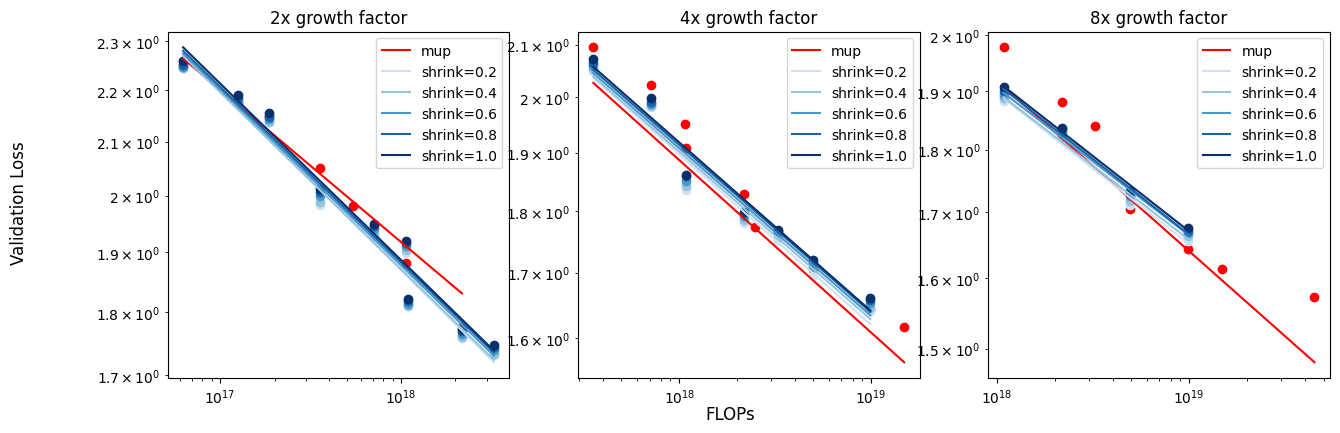

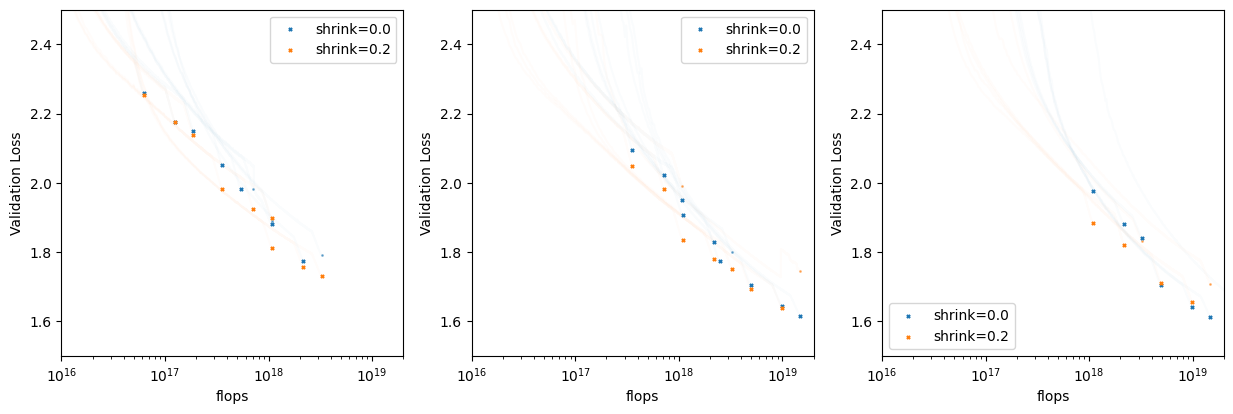

In [24]:
def filter_pairs(df, jump_size=1):
    distinct_values = sorted(
        pd.unique(df[['base_N', 'target_N']].values.ravel())
    )
    pairs = list(zip(distinct_values[:-jump_size], distinct_values[jump_size:]))
    df_filtered = df[df[['base_N', 'target_N']].apply(tuple, axis=1).isin(pairs)]
    return df_filtered

num_jump_sizes = 3
fig, axes = plt.subplots(1, num_jump_sizes, figsize=((5 * num_jump_sizes), 4.5));
fig2, axes2 = plt.subplots(1, num_jump_sizes, figsize=((5 * num_jump_sizes), 4.5));
"""
mup_df = warmstarting_df[warmstarting_df['method']=='mup']
pareto_shrink_df = get_final_points_from_curve_set(
    mup_df,
    unique_col_list,
    x_col=x_col,
    y_col=y_col,
    get_pareto=True,
)
X = pareto_shrink_df[x_col].values
Y = pareto_shrink_df[y_col].values
for i in range(num_jump_sizes):
    plot_line_fit(
        axes[i],
        X,
        Y,
        slope,
        intercept,
        style={"color": "red", "label": f"mup"}
    )
"""

for i in range(num_jump_sizes):

    axes[i].set_title(f"{(2)**(i+1)}x growth factor")
    jump_df = filter_pairs(warmstarting_df, jump_size=i+1)

    shrink_factors = sorted(jump_df['shrink'].unique())
    colors = plt.cm.Blues(np.linspace(0, 1, len(shrink_factors)))
    for j, shrink in enumerate(shrink_factors):
        shrink_df = jump_df[jump_df['shrink']==shrink]
        pareto_shrink_df = get_final_points_from_curve_set(
            shrink_df,
            unique_col_list,
            x_col=x_col,
            y_col=y_col,
            get_pareto=True,
        )
            
        X = pareto_shrink_df[x_col].values
        Y = pareto_shrink_df[y_col].values

        if shrink in [0.0, 0.2]:
                    visualize_train_curves(
                        axes2[i], 
                        shrink_df,
                        unique_col_list,
                        x_col=x_col,
                        y_col=y_col,
                        plot_all_curves=True,
                        plot_final=True,
                        plot_pareto_final=True,
                        ylims=(1.5, 2.5),
                        xlims=(1e16, 2e19),
                        xlog=True,
                        style={"color": plt.get_cmap("tab10").colors[j], "label": f"shrink={shrink}"})
        
        
        # print(f"Slope: {slope}, Intercept: {intercept}, R^2: {r_value**2}")
        if shrink != 0.0:
            slope, intercept, r_value, p_value, std_err = fit_linear_model(X, Y)
            plot_line_fit(
                axes[i],
                X,
                Y,
                slope,
                intercept,
                style={"color": colors[j], "label": f"shrink={shrink}"})
        else:
            plot_line_fit(
                axes[i],
                X,
                Y,
                slope,
                intercept,
                style={"color": "red", "label": f"mup"}
            )

fig.supxlabel("FLOPs")
fig.supylabel(y_col)
for ax in axes.flat:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    leg = ax.get_legend()
    if leg:
        pass # leg.remove()

for ax in axes2.flat:
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())
    
    leg = ax.get_legend()
    if leg:
        pass # leg.remove()

In [16]:
mup_df = warmstarting_df[warmstarting_df['method']=='mup']
pareto_shrink_df = get_final_points_from_curve_set(
    mup_df,
    unique_col_list,
    x_col=x_col,
    y_col=y_col,
    get_pareto=True,
)

In [17]:
pareto_shrink_df

tag,tokens,flops,Train Loss,Validation Loss,tkpm,base_N,target_N,shrink,width,depth,max_lr,warmup,cooldown,seed,method,train_loss_smoothed
3185142,322633728,6.246998e+16,2.179940,2.259872,10.0,14562560,32270848,0.0,256,8,0.0030,0.01,0.2,666,mup,2.195175
3249073,645332992,1.249527e+17,1.858898,2.175067,20.0,14562560,32270848,0.0,256,8,0.0030,0.01,0.2,666,mup,2.078782
3384118,968032256,1.874353e+17,2.422664,2.150423,30.0,14562560,32270848,0.0,256,8,0.0030,0.01,0.2,666,mup,2.080489
3219542,771096576,3.568231e+17,1.947722,2.050542,10.0,32270848,77124608,0.0,512,8,0.0050,0.01,0.2,666,mup,1.928208
3174741,672399360,5.428735e+17,1.988532,1.981091,5.0,77124608,134561280,0.0,768,8,0.0025,0.01,0.2,666,mup,1.910056
3464033,2313551872,1.070591e+18,1.936146,1.880895,30.0,32270848,77124608,0.0,512,8,0.0050,0.01,0.2,666,mup,1.827524
3342692,2690777088,2.172446e+18,1.672778,1.775524,20.0,77124608,134561280,0.0,768,8,0.0025,0.01,0.2,666,mup,1.756535
3180218,1435500544,2.473511e+18,1.708724,1.773099,5.0,77124608,287183360,0.0,1280,8,0.0025,0.01,0.2,666,mup,1.742793
3228528,2871042048,4.947093e+18,1.699052,1.704930,10.0,32270848,287183360,0.0,1280,8,0.0050,0.01,0.2,666,mup,1.687401
3335848,5743116288,9.895965e+18,1.629067,1.642933,20.0,32270848,287183360,0.0,1280,8,0.0050,0.01,0.2,666,mup,1.626583


In [37]:
# if the difference is between 1.5 and 3.5 then they are close to each other
warmstarting_df[['base_N', 'target_N']].drop_duplicates()

tag,base_N,target_N
0,14562560,32270848
147720,14562560,77124608
500760,14562560,134561280
860070,14562560,287183360
1719620,14562560,610488320
1789481,32270848,77124608
1966001,32270848,134561280
2273981,32270848,287183360
2748696,77124608,134561280
2902686,77124608,287183360


In [38]:

distinct_values

for base, target in zip(distinct_values[:-1], distinct_values[1:])


SyntaxError: expected ':' (2762940776.py, line 3)

### Approach 3
